### Luke Traverso
### Professor Binowski
### December 6, 2024
### I want to see how pizza is reviewed around Randolph, NJ. Since there are so many pizza places in so little space, surely people must love the pizza around the town. 

### All the imports that will be used

In [1]:
import requests
import yelpkeys  # file where client_id and api_key is defined with user's private app information
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import nltk
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
nltk.download('punkt')  # For word_tokenize
nltk.download('stopwords')  # For stop words
APIKEY = yelpkeys.api_key
headers = {'Authorization': 'Bearer %s' % yelpkeys.api_key,}

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/luketraverso/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luketraverso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Bring in code that has already been provided

In [6]:
"""
Yelp Fusion API code sample.
This program demonstrates the capability of the Yelp Fusion API
by using the Search API to query for businesses by a search term and location,
and the Business API to query additional information about the top result
from the search query.
Please refer to https://docs.developer.yelp.com/docs/get-started for the API
documentation.
This program requires the Python requests library, which you can install via:
`pip install -r requirements.txt`.
Sample usage of the program:
`python sample.py --term="bars" --location="San Francisco, CA"`
"""
from __future__ import print_function

import argparse
import json
import pprint
import requests
import sys
import urllib


# This client code can run on Python 2.x or 3.x.  Your imports can be
# simpler if you only need one of those.
try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode


# Yelp Fusion no longer uses OAuth as of December 7, 2017.
# You no longer need to provide Client ID to fetch Data
# It now uses private keys to authenticate requests (API Key)
# You can find it on
# https://www.yelp.com/developers/v3/manage_app
API_KEY= yelpkeys.api_key


# API constants, you shouldn't have to change these.
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.
REVIEWS_PATH = '/v3/businesses/{id}/reviews'

### Create functions needed to get the reviews, clean them, then analyze them

In [9]:
def search_businesses(term, location, limit=20):
    url = f"{API_HOST}{SEARCH_PATH}"
    params = {'term': term, 'location': location, 'limit': limit} #dictionary of parameters
    response = requests.get(url, headers=headers, params=params) #request to get reviews for business id
    response.raise_for_status() #check for error
    return response.json()

def fetch_reviews(business_id):
    url = f"{API_HOST}{REVIEWS_PATH.format(id=business_id)}"
    response = requests.get(url, headers=headers) #request to get reviews for business id
    response.raise_for_status() #check for error
    return response.json()

def clean_review_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower()) #remove all of characters and make everything lowercase
    stop_words = set(stopwords.words("english")) #set up removal of stopwords
    tokens = word_tokenize(text) #Split text into individual words
    filtered_words = [word for word in tokens if word not in stop_words] #remove all the stop words
    return " ".join(filtered_words) #bring the review back after filter/cleaning it

# Analyze sentiments
def analyze_sentiments(reviews):
    sentiments = {"positive": 0, "negative": 0, "neutral": 0} #dictionary of values, will have a count to be incremented
    for review in reviews:
        blob = TextBlob(review)
        sentiment = blob.sentiment.polarity #check the reviews sentiments then add on to the counts if positive,negative, or neutral
        if sentiment > 0:
            sentiments["positive"] += 1
        elif sentiment < 0:
            sentiments["negative"] += 1
        else:
            sentiments["neutral"] += 1
    return sentiments

def analyze_sentiments_naivebayes(reviews): 
    sentiments = {"positive": 0, "negative": 0} #same dictionary as before to use to get a count of sentiments
    for review in reviews:
        blob = TextBlob(review, analyzer=NaiveBayesAnalyzer())
        if blob.sentiment.classification == "pos":
            sentiments["positive"] += 1
        else:
            sentiments["negative"] += 1
    return sentiments


### Create the functions that will be used to visualize the reviews sentiments

In [12]:
# Create visualizations
def display_donut_chart(sentiments, title):
    labels = sentiments.keys()
    sizes = sentiments.values()
    plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, wedgeprops={'width': 0.3})
    plt.title(title)
    plt.show()

def display_wordcloud(reviews):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(reviews))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
# Needed help from chatGPT to get the visualizations

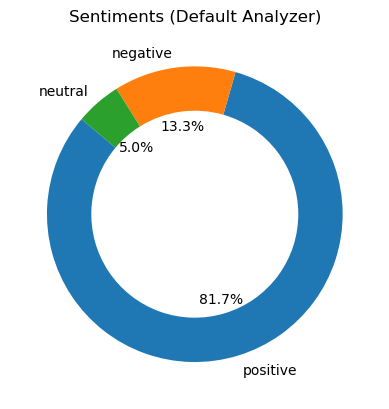

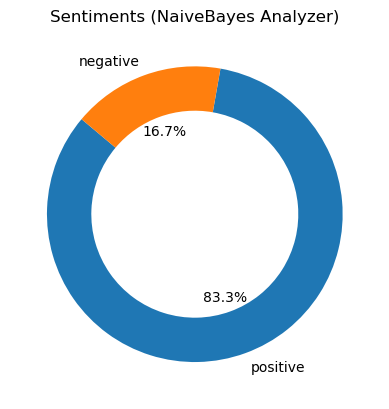

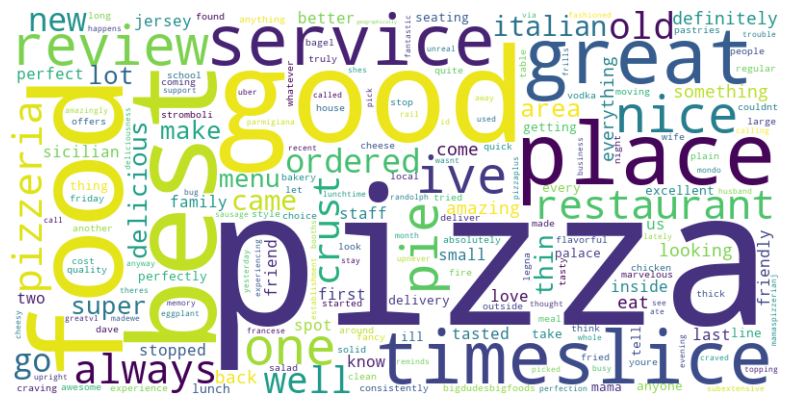

Default sentiment analysis results:
{'negative': 8, 'neutral': 3, 'positive': 49}
Naive Bayes sentiment analysis results:
{'negative': 10, 'positive': 50}


In [22]:
if __name__ == "__main__":
    # Search and fetch reviews
    term = "pizza" #search for a specific cuisine/type of food
    location = "Randolph, NJ" #place where I want to see how pizza is reviewed around the town
    search_results = search_businesses(term, location, limit=20)
    all_reviews = []

    # Gather reviews from all businesses
    for business in search_results.get("businesses", []):
        business_id = business["id"]
        reviews_response = fetch_reviews(business_id)
        reviews = [review["text"] for review in reviews_response.get("reviews", [])]
        all_reviews.extend(reviews)

    if len(all_reviews) < 60:
        print("Not enough reviews fetched.")
    else:
        # Clean reviews
        cleaned_reviews = [clean_review_text(review) for review in all_reviews]

        # Sentiment Analysis
        sentiments_default = analyze_sentiments(cleaned_reviews)
        sentiments_naivebayes = analyze_sentiments_naivebayes(cleaned_reviews)

        # Display results
        display_donut_chart(sentiments_default, "Sentiments (Default Analyzer)")
        display_donut_chart(sentiments_naivebayes, "Sentiments (NaiveBayes Analyzer)")
        display_wordcloud(cleaned_reviews)

        print("Default sentiment analysis results:")
        pprint.pprint(sentiments_default)
        print("Naive Bayes sentiment analysis results:")
        pprint.pprint(sentiments_naivebayes)

### The people in Randolph overwhelmingly enjoy their pizza. Over 80% of people have positive thoughts to share on the pizza that they were reviewing. Some of the most popular words included 'good','great','nice,'best', and of course 'pizza'. 